### Setup imports

In [2]:
import torch
import torch.nn as nn

from easydict import EasyDict
from tqdm import tqdm
import time
from utils import set_seed, inference
from utils.data import build_loader

In [3]:
config = EasyDict({'data_dir': './gan_dataset/brain_2d',
                   'seed': 42,
                   'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                   'batch_size': 10,
                   'num_workers': 1,
                   'lr': 1e-5,
                   'epochs': 20,
                   'save_interval': 10})


set_seed(config.seed)
train_loader, val_ds = build_loader(config)

number data points 7500
num train data points: 6000
num val data points: 1500


# Build Model

In [4]:
class UNetGenerator(nn.Module):
    def __init__(self, in_chan=3):
        super().__init__()

        def conv_block(in_chan, out_chan, kernel_size=3, stride=1, padding=1, bias=True):
            return nn.Sequential(*[nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                                   nn.BatchNorm2d(out_chan),
                                   nn.ReLU()])

        self.enc1 = nn.Sequential(*[conv_block(in_chan, 64),
                                    conv_block(64, 64),
                                   nn.MaxPool2d(kernel_size=2)])

        self.enc2 = nn.Sequential(*[conv_block(64, 128),
                                    conv_block(128, 128),
                                   nn.MaxPool2d(kernel_size=2)])
        
        self.enc3 = nn.Sequential(*[conv_block(128, 256),
                                    conv_block(256, 256),
                                   nn.MaxPool2d(kernel_size=2)])

        
        self.dec4 = nn.Sequential(*[conv_block(256, 128),
                                   nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.dec5 = nn.Sequential(*[conv_block(2*128, 128),
                                    conv_block(128, 64),
                                    nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.dec6 = nn.Sequential(*[conv_block(2 * 64, 64),
                                    nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        dec4 = self.dec4(enc3)
        cat = torch.cat((dec4, enc2), dim=1)
        dec5 = self.dec5(cat)

        cat = torch.cat((dec5, enc1), dim=1)
        dec6 = self.dec6(cat)

        out = self.fc(dec6)

        return out

In [ ]:
import torchvision.models as models
class Discriminator(nn.Module):
    def __init__(self, input_channels=4):
        super(Discriminator, self).__init__()
        # Load the pretrained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first convolution layer to accept input_channels
        self.resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the final fully connected layer to output a single value (real or fake)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.resnet(x))  # Use sigmoid for binary output

In [5]:
generator = UNetGenerator().to(config.device)
discriminator = Discriminator().to(config.device)
model = {'generator': generator, 'discriminator': discriminator}

criterion = nn.BCEWithLogitsLoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=config.lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config.lr)
optimizer ={'generator': optimizer_G, 'discriminator': optimizer_D}

c:\Users\user\anaconda3\envs\brain\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\brain\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Train Model

In [6]:
def train(model, loader, optimizer, criterion, device):
    losses = {'g_loss':[], 'd_loss': []}

    for batch in tqdm(loader):
        real_images = batch["input"].to(device) 
        gt_images = batch["output"].to(device)

        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        # Train Generator
        optimizer['generator'].zero_grad()
        generated_images = model['generator'](real_images)
        fake_out = model['discriminator'](torch.cat((real_images, generated_images), dim=1))
        g_loss = criterion(fake_out, real_labels)
        g_loss.backward()
        optimizer['generator'].step()

        # Train Discriminator
        optimizer['discriminator'].zero_grad()
        real_out = model['discriminator'](torch.cat((real_images, gt_images), dim=1))
        real_loss = criterion(real_out, real_labels)

        fake_out = model['discriminator'](torch.cat((real_images, generated_images.detach()), dim=1))
        fake_loss = criterion(fake_out, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer['discriminator'].step()

        losses['g_loss'].append(g_loss.item())
        losses['d_loss'].append(d_loss.item())

    return losses

In [7]:
global_tr_losses = {'g_loss': [], 'd_loss':[]}
for epoch in range(config.epochs):
    start_time = time.time()

    tr_losses = train(model, train_loader, optimizer, criterion, config.device)
            
    global_tr_losses['g_loss'].append(sum(tr_losses['g_loss']) / len(tr_losses['g_loss']))
    global_tr_losses['d_loss'].append(sum(tr_losses['d_loss']) / len(tr_losses['d_loss']))

    print(f"Epoch [{epoch + 1}/{config.epochs}], "
          f"g_Loss: {global_tr_losses['g_loss'][-1]:.4f}, "
          f"d_Loss: {global_tr_losses['d_loss'][-1]:.4f}, "
          f"Time: {(time.time() - start_time) / 60:.2f}")
            
    if (epoch + 1) % config.save_interval == 0 or epoch == config.epochs - 1:
        torch.save(model['generator'].state_dict(), f"./gan_{(epoch+1):04d}.pth")

100%|██████████| 600/600 [05:00<00:00,  2.00it/s]


Epoch [1/20], g_Loss: 0.5954, d_Loss: 0.6448, Time: 5.01


100%|██████████| 600/600 [05:01<00:00,  1.99it/s]


Epoch [2/20], g_Loss: 0.6545, d_Loss: 0.6748, Time: 5.02


100%|██████████| 600/600 [05:00<00:00,  2.00it/s]


Epoch [3/20], g_Loss: 0.6496, d_Loss: 0.6803, Time: 5.01


100%|██████████| 600/600 [05:02<00:00,  1.98it/s]


Epoch [4/20], g_Loss: 0.6368, d_Loss: 0.6881, Time: 5.04


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [5/20], g_Loss: 0.6354, d_Loss: 0.6808, Time: 4.88


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [6/20], g_Loss: 0.6353, d_Loss: 0.6647, Time: 4.87


100%|██████████| 600/600 [04:53<00:00,  2.05it/s]


Epoch [7/20], g_Loss: 0.6294, d_Loss: 0.6476, Time: 4.89


100%|██████████| 600/600 [04:53<00:00,  2.05it/s]


Epoch [8/20], g_Loss: 0.6672, d_Loss: 0.6746, Time: 4.89


100%|██████████| 600/600 [04:53<00:00,  2.04it/s]


Epoch [9/20], g_Loss: 0.6617, d_Loss: 0.6726, Time: 4.90


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [10/20], g_Loss: 0.6316, d_Loss: 0.6364, Time: 4.87


100%|██████████| 600/600 [04:53<00:00,  2.05it/s]


Epoch [11/20], g_Loss: 0.6375, d_Loss: 0.6018, Time: 4.89


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [12/20], g_Loss: 0.6409, d_Loss: 0.5721, Time: 4.88


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [13/20], g_Loss: 0.6498, d_Loss: 0.5574, Time: 4.88


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [14/20], g_Loss: 0.6549, d_Loss: 0.5529, Time: 4.87


100%|██████████| 600/600 [04:53<00:00,  2.05it/s]


Epoch [15/20], g_Loss: 0.6590, d_Loss: 0.5485, Time: 4.89


100%|██████████| 600/600 [04:56<00:00,  2.02it/s]


Epoch [16/20], g_Loss: 0.6691, d_Loss: 0.5329, Time: 4.94


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Epoch [17/20], g_Loss: 0.6685, d_Loss: 0.5362, Time: 4.88


100%|██████████| 600/600 [04:53<00:00,  2.04it/s]


Epoch [18/20], g_Loss: 0.6716, d_Loss: 0.5332, Time: 4.89


100%|██████████| 600/600 [04:53<00:00,  2.04it/s]


Epoch [19/20], g_Loss: 0.6764, d_Loss: 0.5231, Time: 4.90


100%|██████████| 600/600 [04:53<00:00,  2.05it/s]

Epoch [20/20], g_Loss: 0.6761, d_Loss: 0.5248, Time: 4.88


C:\Users\user\AppData\Local\Temp\ipykernel_16276\2502243033.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gan_0020.pth'))


0.005964632728137076


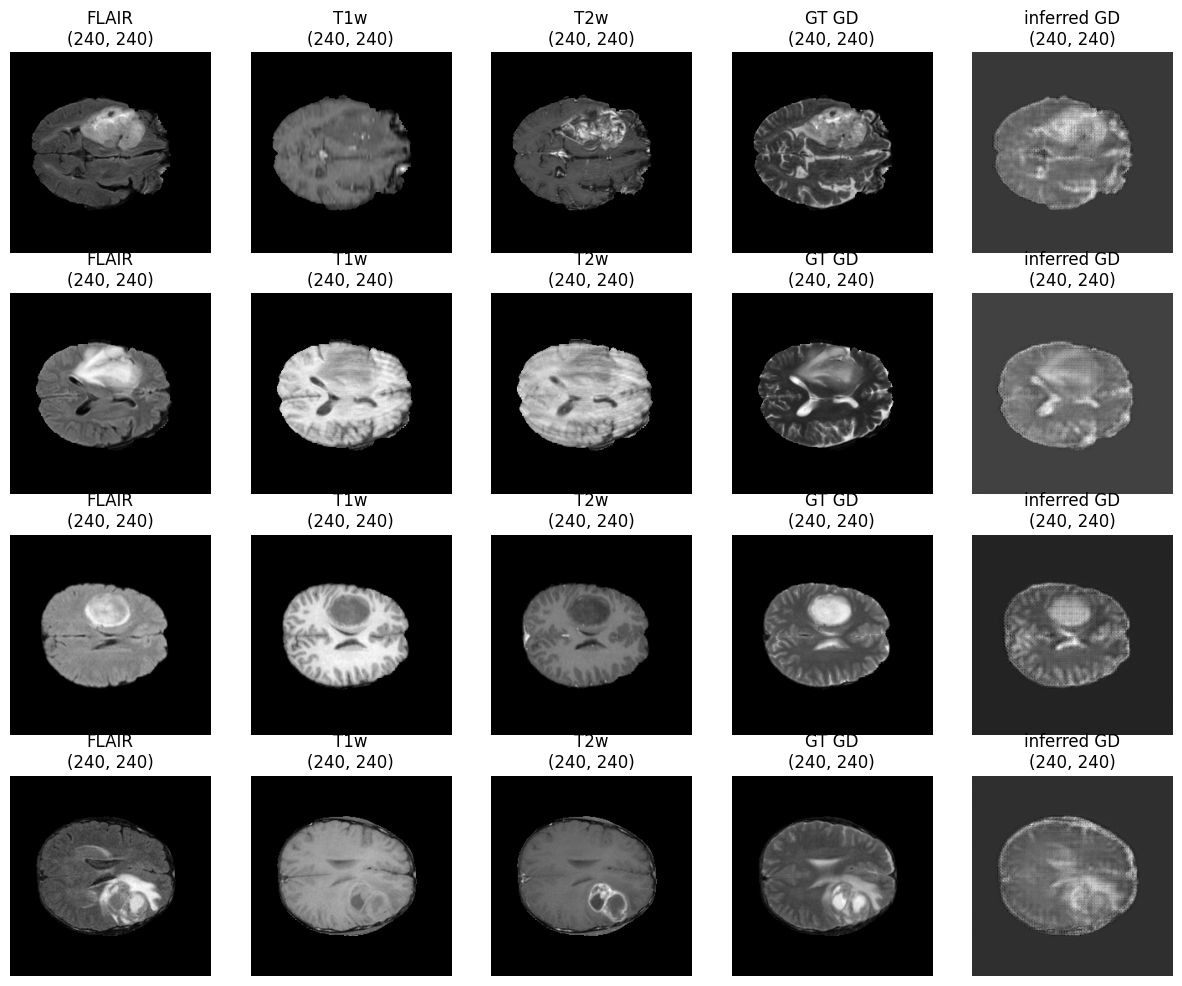

In [18]:
model = UNetGenerator().to(config.device)
model.load_state_dict(torch.load('gan_0020.pth'))
inference(model, val_ds, config, num_data=4)